# The Pedal Board Finder
## A Google Shopping scraper that utilizes fundamental NLP techniques to analyze review data for different products given a search query.
### My goal is to find the best reviewed guitar effect pedals. First, I'll perform sentiment analysis on review data, then I'll topic model the positive and negative class to see what good/bad things people are saying about the product.

# 1 - Data Gathering/Processing/EDA
---
## 1.1 - Review Data Gathering. 

In [541]:
from pyfuncs import scraper
from time import sleep
import pandas as pd

In [542]:
search_terms = ['fuzz pedal', 'delay pedal', 'wah pedal', 'octave pedal']


In [543]:
#These are the pedal's I'm interested in. I ran this scraper already. The google shopping scraper can be found in 
#notebooks/pyfuncs/scraper

def get_review_data():
    '''Uses the google shopping scraper class found in pyfuncs/scraper to fetch reviews 
    for each product given a search query.
    
    ::params:: search_terms: list of strings of terms you're interested in scraping.
    
    ::returns:: None, saves pickled dataframe objects for each search term in working directory.
    '''
    for term in search_terms:
        try:
            Shopper = scraper.Google_Shopping_Scraper(term, n_reviews=200, n_pages=10)
            sleep(10)
        except:
            print('retrying search')
            sleep(1)
            Shopper.driver.close()
            sleep(1)
            Shopper = scraper.Google_Shopping_Scraper(term, n_reviews=200, n_pages=10)
        Shopper.get_all_pages()
        corpus_df = pd.DataFrame(Shopper.all_reviews)
        term = term.replace(' ','_')
        corpus_df.to_pickle(f'{term}.pkl')
        Shopper.driver.close()
    pass

## 1.2 - Text Cleaning.

In [544]:
from pyfuncs import text_funcs

In [545]:
for term in search_terms:
    raw_df = pd.read_pickle(f'{term.replace(" ", "_")}.pkl')
    clean_reviews = text_funcs.cleaner(raw_df['review'], remove_non_english = False)
    raw_df['review'] = clean_reviews
    raw_df.to_pickle(f'{term.replace(" ", "_")}_cleaned.pkl')

## 1.3 - EDA.

In [546]:
import seaborn as sns
import matplotlib.pyplot as plt

corpus = dict()
for term in search_terms:
    print(term)
    corpus[f"{term.replace(' ', '_').replace('_cleaned', '')}"] = \
        pd.read_pickle(f"{term.replace(' ', '_')}_cleaned.pkl")

fuzz pedal
delay pedal
wah pedal
octave pedal


In [17]:
def get_class_counts(corpus_dict, rating_col):
    '''Returns class counts to check for class imbalance'''
    fig, axs = plt.subplots(2, 2, figsize=(20,20))
    for i, df_key in enumerate(corpus_dict.keys()):
        counts = corpus[df_key][rating_col].value_counts()
        sns.barplot(counts.index, counts.values, ax=axs.flat[i])
        axs.flat[i].set_title(str(df_key).replace("_", " "), size=30)
        axs.flat[i].tick_params(axis='both', which='major', labelsize=25)
    pass

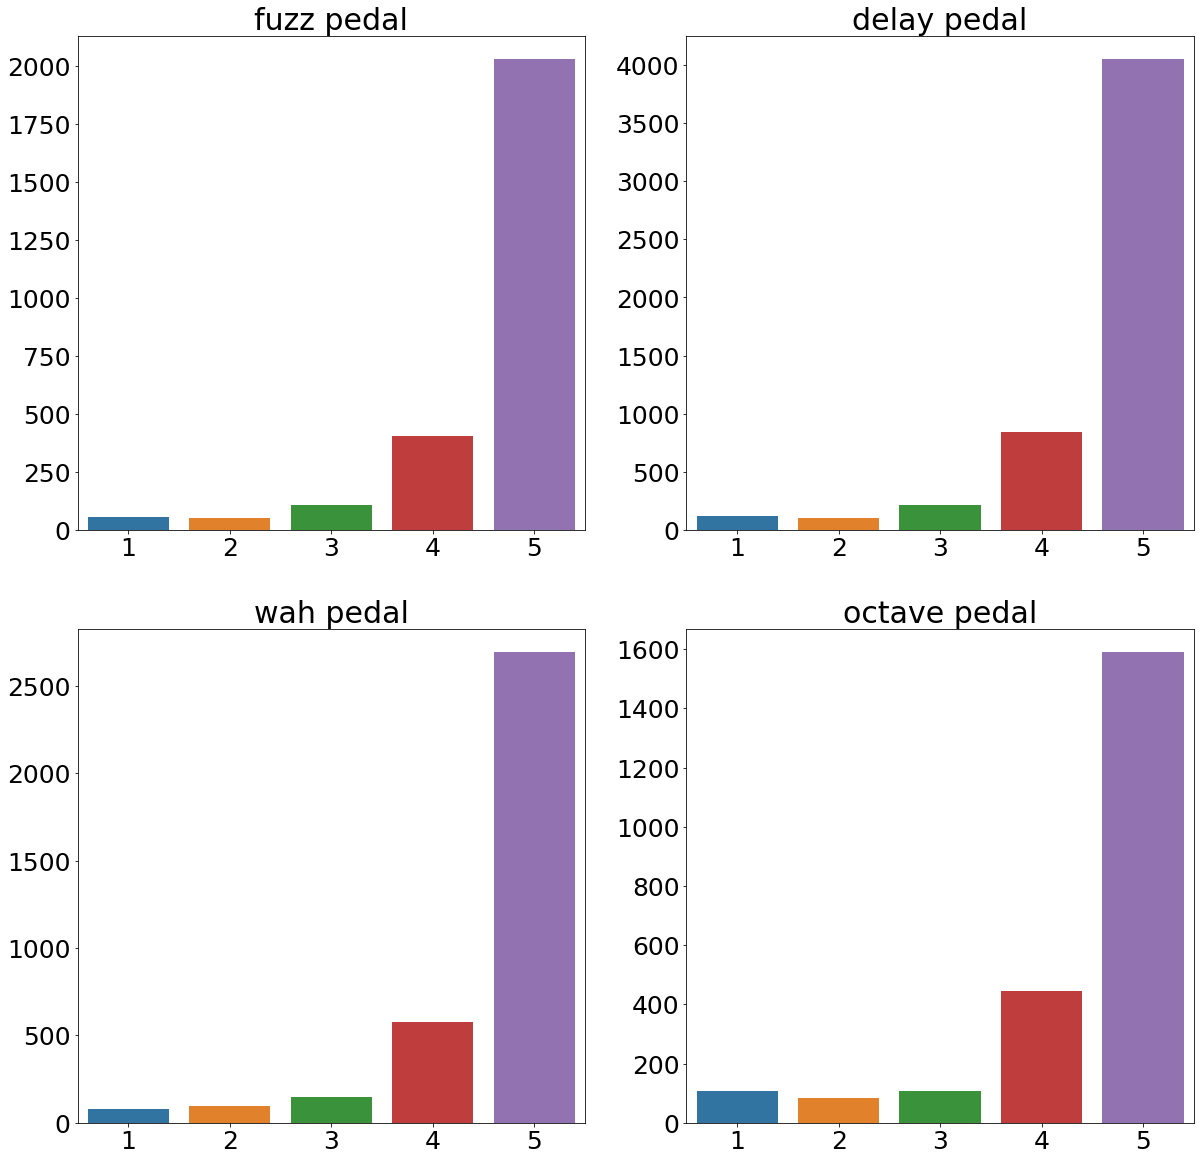

In [18]:
get_class_counts(corpus, 'review_ratings')

### There does seem to be a fairly large class imbalance, Will try to group ratings 1,2 -> negative, 3-> neutral, 4,5-> positive.

In [547]:
for df_key in corpus.keys():
    corpus[df_key]['2_group_rating'] = text_funcs.get_pos_neg_neut(corpus[df_key]['review_ratings'], neutral_class=False)
    corpus[df_key]['3_group_rating'] = text_funcs.get_pos_neg_neut(corpus[df_key]['review_ratings'])

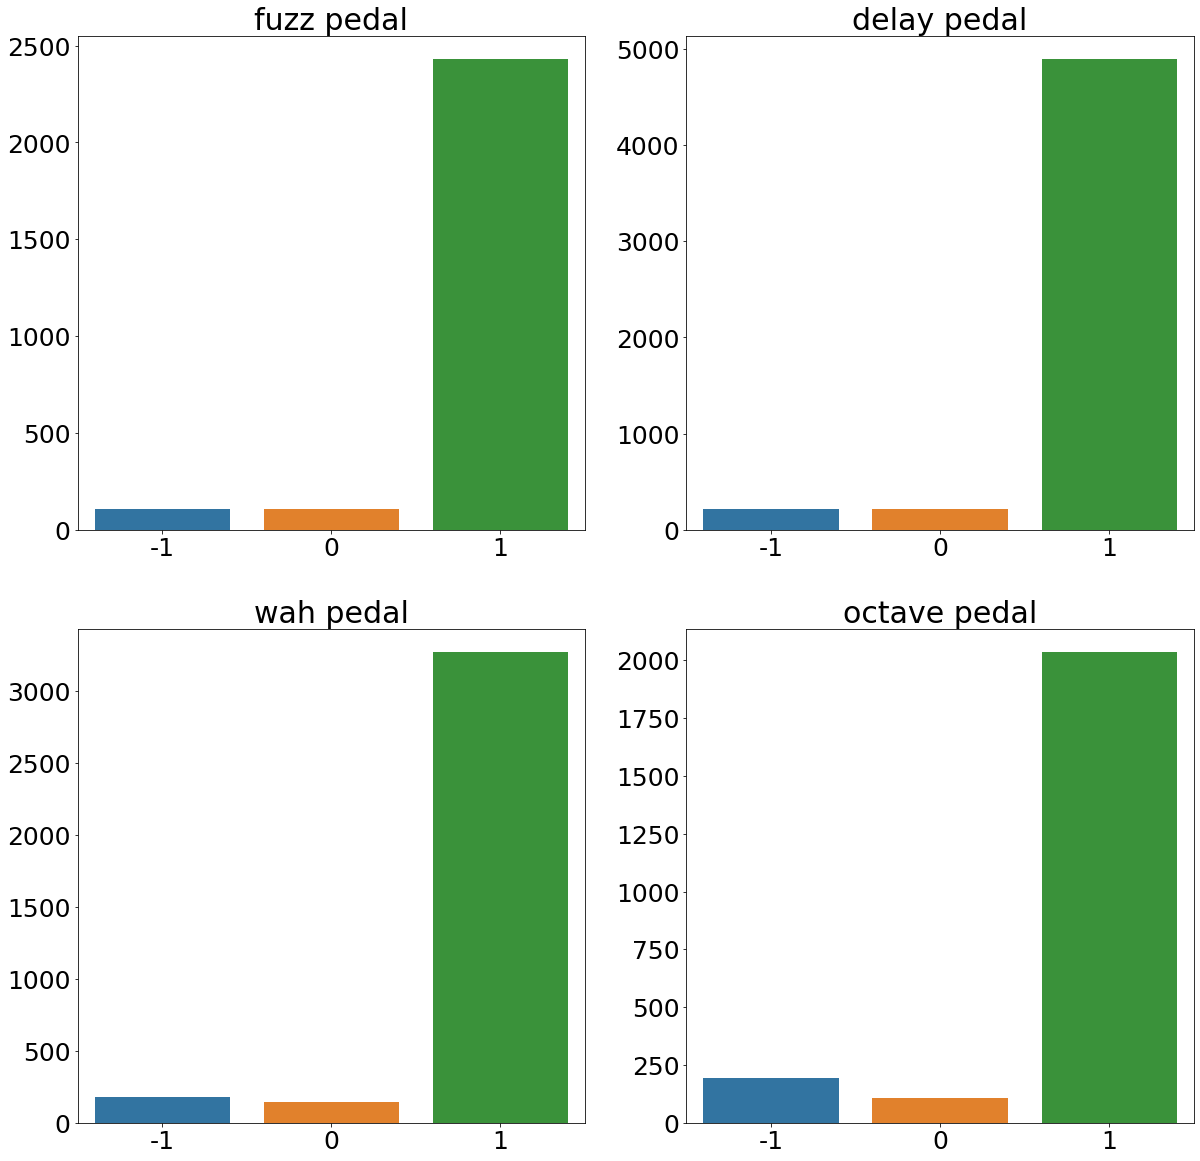

In [20]:
get_class_counts(corpus, '3_group_rating')

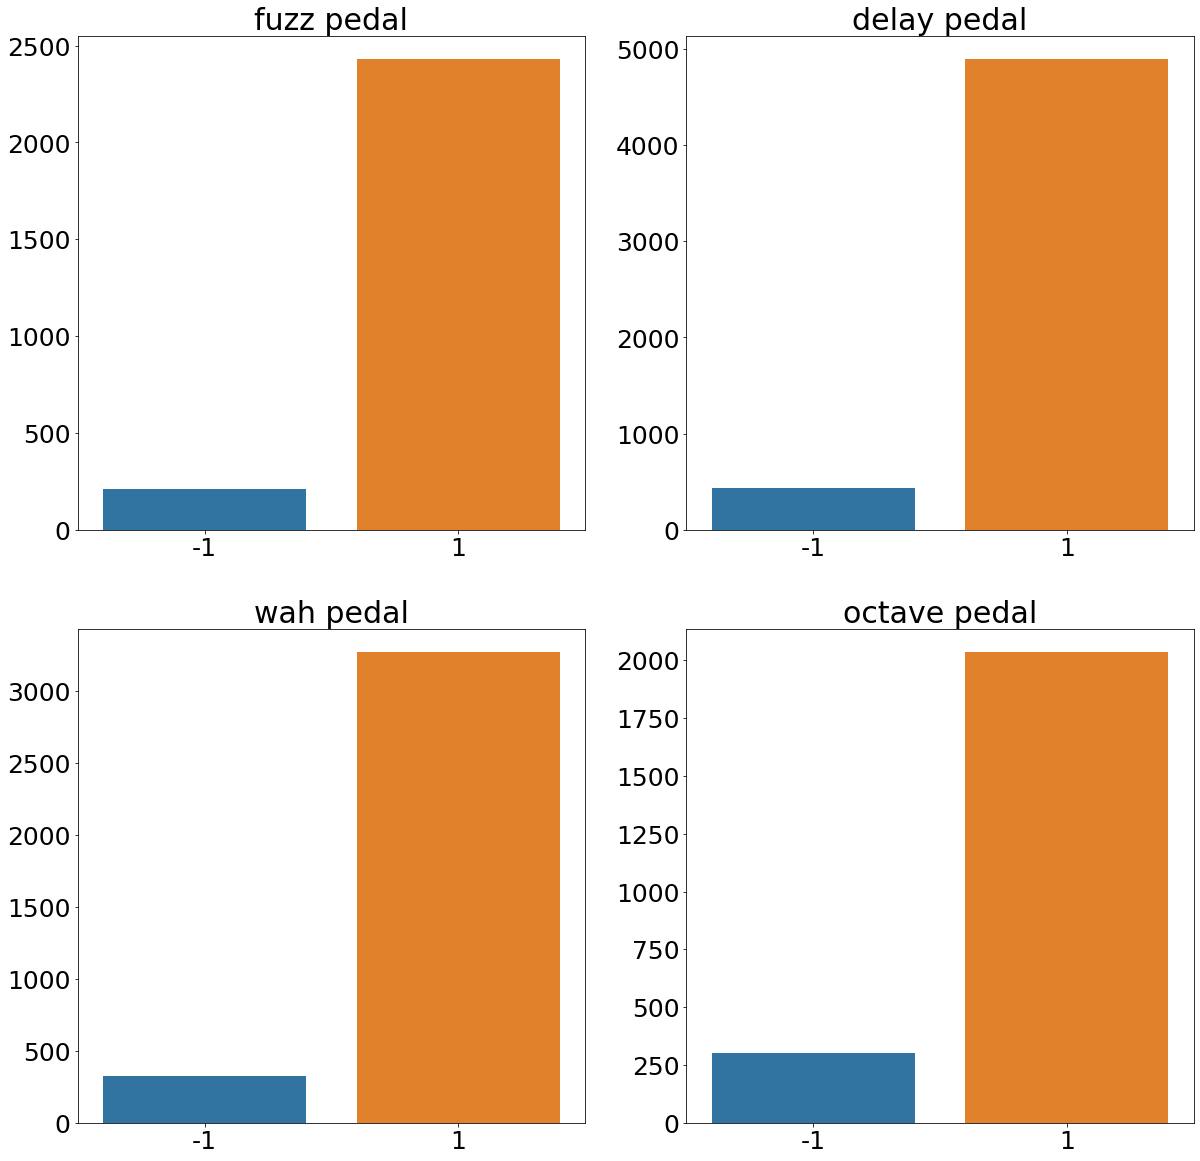

In [21]:
get_class_counts(corpus, '2_group_rating')

## 1.4 - Train/Test Split 

In [22]:
from sklearn.model_selection import train_test_split
from collections import defaultdict

In [23]:
octave = corpus['octave_pedal']
fuzz = corpus['fuzz_pedal']
delay = corpus['delay_pedal']
wah = corpus['wah_pedal']
dfs = [octave, fuzz, delay, wah]

def train_test(dfs):
    '''splits each product review df into train/test sets. 
    returns train_corpus/test_corpus dictionaries'''
    test_corpus = defaultdict(list)
    train_corpus = defaultdict(list)
    for df in dfs:
        X, y = df['review'], df['2_group_rating']
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        train_corpus['pedal'].append(df['search'][0])
        test_corpus['pedal'].append(df['search'][0])
        train_corpus['y'].append(y_train)
        test_corpus['y'].append(y_test)
        train_corpus['X'].append(X_train)
        test_corpus['X'].append(X_test)
    return train_corpus, test_corpus

In [24]:
Train, Test = train_test(dfs)

In [25]:
Test['X']

[867     review of digitech drop pedal bought for frien...
 1208    very nice pedal i was looking for a good whamm...
 133                          great pedal would recommend 
 2202    sub n up first octave pedal ever like the effe...
 818     read the review so i could not be happier with...
                               ...                        
 534     review of tc electronic sub n up solid octave ...
 2160    review of tc electronic sub n up really love t...
 1839    ok as a multifx pedal for the price one thing ...
 1349                       sounds nothing like the video 
 592     get em and like em i put a set on my cheap dol...
 Name: review, Length: 584, dtype: object,
 967     awesome incredibly versatile fuzz it can appro...
 2353    beautiful pedal and lots of options love the r...
 1204    lightweight i was very happy with this product...
 871     all hail the electro harmonix this pedal is th...
 367     good value for money i really like the differe...
             

# 2 - Sentiment Analysis
---
## 2.1 Supervised Sentiment Analysis with Rule Based Tools.
### 2.1.1 Vader Sentiment.

In [26]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [31]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

In [32]:
def get_vader_scores(Train):
    scores = defaultdict(list)
    for ix in range(4):
        for review in Train['X'][ix]:
            scores[ix].append(sentiment_analyzer_scores(review))
    return scores

In [33]:
scores = get_vader_scores(Train)

In [34]:
def predict_vader_sentiment(scores):
    '''Predicts all scores for each of the 4 products'''
    predictions = defaultdict(list)
    for ix in range(4):
        for review_score in scores[ix]:
            if review_score['neg'] >= review_score['pos']:
                predictions[ix].append(-1)
            else:
                predictions[ix].append(1)
    return predictions

In [35]:
ypred = predict_vader_sentiment(scores)

In [36]:
from sklearn.metrics import classification_report

def get_all_reports(ypred, Train):
    for ix in range(4):
        print(Train['pedal'][ix])
        print(classification_report(Train['y'][ix], ypred[ix]))
        print('\n')
    pass

get_all_reports(ypred, Train)

octave pedal
              precision    recall  f1-score   support

          -1       0.45      0.43      0.44       213
           1       0.92      0.93      0.92      1539

    accuracy                           0.87      1752
   macro avg       0.69      0.68      0.68      1752
weighted avg       0.86      0.87      0.87      1752



fuzz pedal
              precision    recall  f1-score   support

          -1       0.27      0.36      0.31       158
           1       0.94      0.92      0.93      1822

    accuracy                           0.87      1980
   macro avg       0.61      0.64      0.62      1980
weighted avg       0.89      0.87      0.88      1980



delay pedal
              precision    recall  f1-score   support

          -1       0.30      0.47      0.37       335
           1       0.95      0.90      0.92      3662

    accuracy                           0.86      3997
   macro avg       0.62      0.68      0.64      3997
weighted avg       0.89      0.86 

#### It seems like vader sentiment has a hard time predicting the negative review class. I'll worry about f1 score

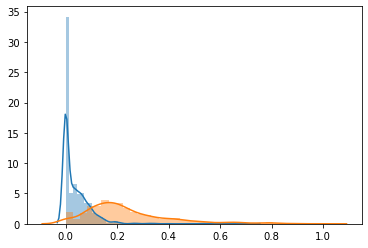

In [23]:
negative_scores = [score['neg'] for score in scores[0]]
positive_scores = [score['pos'] for score in scores[0]]
sns.distplot(negative_scores)
sns.distplot(positive_scores)
plt.show()

In [24]:
def predict_vader_sentiment_weighted(scores, neg_weight=1):
    '''Predicts all scores for each of the 4 products'''
    predictions = defaultdict(list)
    for ix in range(4):
        for review_score in scores[ix]:
            if review_score['neg']*neg_weight >= review_score['pos']:
                predictions[ix].append(-1)
            else:
                predictions[ix].append(1)
    return predictions

In [25]:
ypred = predict_vader_sentiment_weighted(scores, neg_weight=1.5)
get_all_reports(ypred, Train)

octave pedal
              precision    recall  f1-score   support

          -1       0.45      0.56      0.50       222
           1       0.93      0.90      0.92      1530

    accuracy                           0.86      1752
   macro avg       0.69      0.73      0.71      1752
weighted avg       0.87      0.86      0.87      1752



fuzz pedal
              precision    recall  f1-score   support

          -1       0.24      0.48      0.32       152
           1       0.95      0.87      0.91      1828

    accuracy                           0.84      1980
   macro avg       0.60      0.68      0.62      1980
weighted avg       0.90      0.84      0.87      1980



delay pedal
              precision    recall  f1-score   support

          -1       0.23      0.61      0.34       321
           1       0.96      0.83      0.89      3676

    accuracy                           0.81      3997
   macro avg       0.60      0.72      0.61      3997
weighted avg       0.90      0.81 

It seems like vader sentiment just isn't going to cut it.

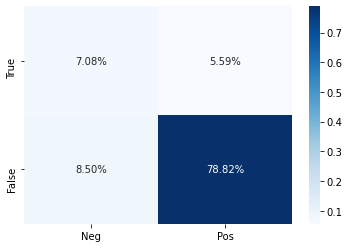

In [26]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(Train['y'][0], ypred[0])
y_ticks = ['True', 'False']
x_ticks = ['Neg', 'Pos']
labels = [y_ticks, x_ticks]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues', xticklabels=x_ticks, yticklabels=y_ticks);

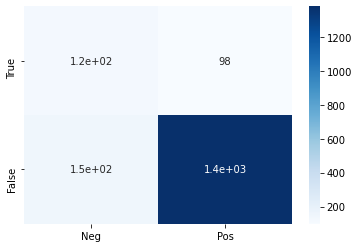

In [27]:
y_ticks = ['True', 'False']
x_ticks = ['Neg', 'Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf, annot=True, cmap='Blues', xticklabels=x_ticks, yticklabels=y_ticks);

## 2.2 Sentiment with Dimensionality Reduction
### 2.2.1 Model Selection

In [27]:
#first I'll work with the delay pedal train set
X = Train['X'][3]
test = Test['X'][3]
y_test = Test['y'][3]
y_train = Train['y'][3]

In [28]:
X_train, tfidf_vect = text_funcs.tfidf_vectorize(X, max_doc_freq=.8)
X_test = tfidf_vect.transform(test)
X_test = pd.DataFrame(X_test.toarray(), columns = tfidf_vect.get_feature_names())
X_test.index = test.index
X_train.index = X.index #keep original index

In [29]:
#PCA
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= .95) + 1

In [30]:
d

1165

In [31]:
X_train.shape

(2695, 7537)

In [188]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(n_neighbors=2)
knc.fit(X_train, y_train)
y_pred = knc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.15      1.00      0.27        76
           1       1.00      0.49      0.66       823

    accuracy                           0.54       899
   macro avg       0.58      0.75      0.46       899
weighted avg       0.93      0.54      0.63       899



In [189]:
from sklearn.naive_bayes import GaussianNB
cnb = GaussianNB()
cnb.fit(X_train, y_train)
y_pred = cnb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.40      0.76      0.53        76
           1       0.98      0.90      0.93       823

    accuracy                           0.88       899
   macro avg       0.69      0.83      0.73       899
weighted avg       0.93      0.88      0.90       899



In [190]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.67      0.80        76
           1       0.97      1.00      0.99       823

    accuracy                           0.97       899
   macro avg       0.99      0.84      0.89       899
weighted avg       0.97      0.97      0.97       899



In [191]:
from sklearn.ensemble import GradientBoostingClassifier
forest = GradientBoostingClassifier()
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.87      0.36      0.50        76
           1       0.94      1.00      0.97       823

    accuracy                           0.94       899
   macro avg       0.91      0.68      0.74       899
weighted avg       0.94      0.94      0.93       899



It seems like RandomForest does best, Let's grid search to find the best kernel for PCA.

In [209]:
from sklearn.decomposition import KernelPCA

#getting ideal n_components by getting the explained variance ratio:
kpca = KernelPCA(kernel='rbf')
kpca.fit(X_train)

#Kernel PCA doesn't have .explained_variance_ratio_, so I made my own
kpca_transform = kpca.fit_transform(X_train)
explained_variance = np.var(kpca_transform, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
cumsum = np.cumsum(explained_variance_ratio)

d = np.argmax(cumsum >= .95) + 1

In [210]:
d

1156

In [211]:
#getting ideal n_components by getting the explained variance ratio:
kpca = KernelPCA(kernel='sigmoid')
kpca.fit(X_train)

#Kernel PCA doesn't have .explained_variance_ratio_, so I made my own
kpca_transform = kpca.fit_transform(X_train)
explained_variance = np.var(kpca_transform, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
cumsum = np.cumsum(explained_variance_ratio)

d = np.argmax(cumsum >= .95) + 1

In [212]:
d

1156

It seems like the explained variance ratio is relatively independent of the kernel, so I'll set n_components to 1150

In [32]:
#Implementing f1_scorer
from sklearn.metrics import make_scorer
f1_scorer = make_scorer(f1_score)

NameError: name 'f1_score' is not defined

In [218]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

clf = Pipeline([
    ('kpca', KernelPCA()),
    ('forest', RandomForestClassifier())
])

param_grid = [{
    "kpca__n_components": [1150],
    "kpca__gamma": np.linspace(0.03, 0.05, 3),
    "kpca__kernel": ['linear', 'rbf', 'sigmoid']
}]

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring=f1_scorer)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA()),
                                       ('forest', RandomForestClassifier())]),
             param_grid=[{'kpca__gamma': array([0.03, 0.04, 0.05]),
                          'kpca__kernel': ['linear', 'rbf', 'sigmoid'],
                          'kpca__n_components': [1150]}],
             scoring=make_scorer(f1_score))

In [219]:
grid_search.best_params_

{'kpca__gamma': 0.03, 'kpca__kernel': 'linear', 'kpca__n_components': 1150}

Let's do one final search to optimize gamma.

In [220]:
clf = Pipeline([
    ('kpca', KernelPCA()),
    ('forest', RandomForestClassifier())
])

param_grid = [{
    "kpca__n_components": [1150],
    "kpca__gamma": np.linspace(0.01, 0.039, 30),
}]

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring=f1_scorer)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA()),
                                       ('forest', RandomForestClassifier())]),
             param_grid=[{'kpca__gamma': array([0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039]),
                          'kpca__n_components': [1150]}],
             scoring=make_scorer(f1_score))

In [223]:
grid_search.best_params_

{'kpca__gamma': 0.01, 'kpca__n_components': 1150}

In [224]:
#compare performance of grid searched model vs regular pca + forest
estimator = grid_search.best_estimator_
estimator.fit(X_train, y_train)

initial_estimator = Pipeline([
    ('pca', PCA(n_components=1150)),
    ('forest', RandomForestClassifier())
])

initial_estimator.fit(X_train, y_train)

ypred_e = estimator.predict(X_test)
ypred_ie = initial_estimator.predict(X_test)

print('Grid Search Estimator Results')
print(classification_report(y_test, ypred_e))
print('\n')
print('Initial Estimator Results')
print(classification_report(y_test, ypred_ie))

Grid Search Estimator Results
              precision    recall  f1-score   support

          -1       1.00      0.66      0.79        76
           1       0.97      1.00      0.98       823

    accuracy                           0.97       899
   macro avg       0.98      0.83      0.89       899
weighted avg       0.97      0.97      0.97       899



Initial Estimator Results
              precision    recall  f1-score   support

          -1       1.00      0.66      0.79        76
           1       0.97      1.00      0.98       823

    accuracy                           0.97       899
   macro avg       0.98      0.83      0.89       899
weighted avg       0.97      0.97      0.97       899



I'll stick with the initial pipeline since the kernal pca didn't improve my results too much.

In [225]:
sentiment_analyzer = initial_estimator

### 2.2.2 Extracting Sentiment With selected model

In [37]:
import pickle

In [38]:
%cd /home/dyllanjr/Documents/NLP_M4/models

/home/dyllanjr/Documents/NLP_M4/models


In [33]:
f1_scores = []
for ix in range(4):
    X = Train['X'][ix]
    test = Test['X'][ix]
    y_test = Test['y'][ix]
    y_train = Train['y'][ix]
    X_train, tfidf_vect = text_funcs.tfidf_vectorize(X, max_doc_freq=.8)
    X_test = tfidf_vect.transform(test)
    X_test = pd.DataFrame(X_test.toarray(), columns = tfidf_vect.get_feature_names())
    X_test.index = test.index #keep original index
    X_train.index = X.index #keep original index
    sentiment_analyzer.fit(X_train, y_train)
    ypred = sentiment_analyzer.predict(X_test)
    f1_scores.append(f1_score(y_test, ypred))
    
    
    filename = f'{Train["pedal"][ix]}.pkl'
    pickle.dump(sentiment_analyzer, open(filename, 'wb'))


NameError: name 'sentiment_analyzer' is not defined

In [333]:
print(classification_report(ypred, y_test))

              precision    recall  f1-score   support

          -1       0.66      1.00      0.79        50
           1       1.00      0.97      0.98       849

    accuracy                           0.97       899
   macro avg       0.83      0.98      0.89       899
weighted avg       0.98      0.97      0.97       899



In [243]:
print(f1_scores, np.mean(f1_scores))

[0.9541984732824427, 0.966183574879227, 0.9716535433070865, 0.9844497607655502] 0.9691213380585767


Works very well! I was going to try to do sentiment with word embeddings but I don't think it'd be very useful.

## 2.3 Extracting Highest and Lowest rated product for each pedal

In [548]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier


In [549]:
pedals = ['delay_pedal', 'fuzz_pedal', 'octave_pedal', 'wah_pedal']

In [551]:
from pyfuncs import text_funcs
#Assigns sentiment for each pedal for each listing for each review
for pedal in pedals:
    reviews = corpus[pedal]['review']
    X, tfidf_vect = text_funcs.tfidf_vectorize(reviews, max_doc_freq=.8)

    X_reduced = PCA(n_components=1150).fit_transform(X)
    forest = RandomForestClassifier()
    forest.fit(X_reduced, corpus[pedal]['2_group_rating'])
    sentiment = forest.predict(X_reduced)
    corpus[pedal]['sent_pred'] = sentiment

In [552]:
best_and_worst_products = {}
#Grabs the most positive and most negative sentiment listings:
for pedal in pedals:
    group = corpus[pedal].groupby(['listing'])['sent_pred'].agg([('sum', lambda x: x.mean()), 'count'])
    #Getting listings with more than 50 reviews
    group = group[group['count'] > 50]
    group = group['sum']
    most_positive = group.idxmax()
    most_negative = group.idxmin()
    best_and_worst_products[pedal] = (most_positive, most_negative)


In [553]:
best_and_worst_products

{'delay_pedal': ('TC Electronic Flashback Delay & Looper Effects Pedal',
  'Behringer DR600 Digital Reverb Pedal Behringer ZB471'),
 'fuzz_pedal': ('JHS Mini Foot Fuzz V2 Silicon Fuzz Pedal',
  'Electro-Harmonix Satisfaction Fuzz Pedal'),
 'octave_pedal': ('DigiTech Whammy 5 Expressive Pitch Shifting Guitar Effects Pedal',
  'Behringer FX600 Multi-Effects Pedal'),
 'wah_pedal': ('Dunlop Dimebag Cry Baby from Hell Wah Pedal',
  'Boss AW-3 Dynamic Wah Pedal')}

## 3 - Topic Modelling
---
### 3.1 - TFIDF + NMF

In [582]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

### Delay Pedal Topics

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

#best and worst product from delay reviews
delay_df = corpus['delay_pedal']
best_listing = best_and_worst_products['delay_pedal'][0]
worst_listing = best_and_worst_products['delay_pedal'][1]
best_df = delay_df[delay_df['listing'] == best_listing]
worst_df = delay_df[delay_df['listing'] == worst_listing]
best_reviews = best_df.review
worst_reviews = worst_df.review

In [41]:
best_pros = (best_df.sent_pred == 1)
best_cons = (best_df.sent_pred == -1)
worst_pros = (worst_df.sent_pred == 1)
worst_cons = (worst_df.sent_pred == -1)

In [42]:
print('worst sentiment score:', worst_df.sent_pred.mean())
print('best sentiment score:', best_df.sent_pred.mean())

worst sentiment score: 0.6527777777777778
best sentiment score: 0.9506172839506173


In [146]:
#I'll try a vanilla tfidf first
tfidf = TfidfVectorizer(max_df=.8, ngram_range=(4,4))
best_tfidf = tfidf.fit_transform(best_reviews)
best_tokens = tfidf.get_feature_names()
worst_tfidf = tfidf.fit_transform(worst_reviews)
worst_tokens = tfidf.get_feature_names()

In [169]:
best_tfidf.shape

(162, 6403)

In [153]:
#fitting nmf to best review listing
best_nmf_pros = NMF(n_components=2).fit(best_tfidf[best_pros])
best_nmf_cons = NMF(n_components=2).fit(best_tfidf[best_cons])

worst_nmf_pros = NMF(n_components=2).fit(worst_tfidf[worst_pros])
worst_nmf_cons = NMF(n_components=2).fit(worst_tfidf[worst_cons])

/home/dyllanjr/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [154]:
print_top_words(best_nmf_pros, best_tokens, 5)
print_top_words(best_nmf_cons, best_tokens, 5)

Topic #0: boss compact reverb pedal of boss compact reverb review of boss compact compact reverb pedal excellent compact reverb pedal great
Topic #1: is real hands on this is real hands hands on product review real hands on product on product review from

Topic #0: fungerede egentlig okde første den fungerede egentlig okde horrible service took weeks weeks to receive it use sweetwater from now
Topic #1: not that great not as everyone says it not as great as that great not as as great as everyone



In [155]:
print_top_words(worst_nmf_pros, worst_tokens, 5)
print_top_words(worst_nmf_cons, worst_tokens, 5)

Topic #0: for over year and using this analog delay delay have been using over year and have this analog delay for
Topic #1: easy to use and to use and set fun good sound battery set upgreat fun good and set upgreat fun

Topic #0: days thennuttin you get for days thennuttin you worked for days thennuttin thennuttin you get what what you pay for
Topic #1: but it does work repeats but it does there its not bad not the best out to set the repeats



This does okay, but I'd like to take a look at some other options

### 3.2 - TFIDF + LDA (Latent Dirichlet Allocation)

In [150]:
from sklearn.decomposition import LatentDirichletAllocation
best_lda_pros = LatentDirichletAllocation(n_components=5).fit(best_tfidf[best_pros])
best_lda_cons = LatentDirichletAllocation(n_components=5).fit(best_tfidf[best_cons])

worst_lda_pros = LatentDirichletAllocation(n_components=5).fit(worst_tfidf[worst_pros])
worst_lda_cons = LatentDirichletAllocation(n_components=5).fit(worst_tfidf[worst_cons])

In [151]:
print_top_words(best_lda_pros, best_tokens, 5)
print_top_words(best_lda_cons, best_tokens, 5)

Topic #0: cool clear sounding reverb review of boss compact boss compact reverb pedal of boss compact reverb quality material and sound
Topic #1: absolutely lots of headroom very good works perfectly review of boss compact of boss compact reverb boss compact reverb pedal
Topic #2: boss compact reverb pedal of boss compact reverb review of boss compact does what want and what want and beyond
Topic #3: review of boss compact boss compact reverb pedal of boss compact reverb the best reverb ever reverb ever legend reverb
Topic #4: buy again its great would buy again its er god it is god it is good den er god it

Topic #0: fungerede egentlig okde første den fungerede egentlig okde okde første min hvorefter lyd end min roland hvorefter batteriet var flad
Topic #1: to receive it poor service took weeks to service will use sweetwater took weeks to receive horrible service took weeks
Topic #2: to receive it poor service took weeks to service will use sweetwater took weeks to receive horrible se

In [152]:
print_top_words(worst_lda_pros, best_tokens, 5)
print_top_words(worst_lda_cons, best_tokens, 5)

Topic #0: even used for djing ethereal shimmer yhis pedal pedal the shimmer setting from mark sam ash epr sam ash music
Topic #1: compact reverb pedal item familiar with the previous best reverb on the beat boss and when decent price bought this
Topic #2: the boss does that easy to forget which some effects pedals this for me it does tag versus lot of
Topic #3: been favorite of mine out many reverb pedals reverb pedal excellent cannot keep this one in delay let friend of
Topic #4: great ambient reverb this that is to say easy to dial in or recording the modulate bedre lyd end min

Topic #0: fender deluxe reverb amplifier to get into the controls are intuitive and sounds are good but ton of options very
Topic #1: peddle for me this tones instantly from subtle on every guitar players it stands out for modes the first four
Topic #2: time control would thoroughly looked at the strymon the modulated setting but is awesome state of of fun but didnt
Topic #3: maximum cosmos and sounds my favo

That seems to work a little better! Now I'll look as LSA

### 3.3 - TFIDF + LSA (Truncated Singular Value Decomposition)

In [115]:
from sklearn.decomposition import TruncatedSVD
best_lsa_pros = TruncatedSVD(n_components=4).fit(best_tfidf[best_pros])
best_lsa_cons = TruncatedSVD(n_components=4).fit(best_tfidf[best_cons])

worst_lsa_pros = TruncatedSVD(n_components=4).fit(worst_tfidf[worst_pros])
worst_lsa_cons = TruncatedSVD(n_components=4).fit(worst_tfidf[worst_cons])

In [116]:
print_top_words(best_lsa_pros, best_tokens, 5)
print_top_words(best_lsa_cons, best_tokens, 5)

Topic #0: pedal reverb great boss review
Topic #1: compact review boss kit piece
Topic #2: great pedal price buy worth
Topic #3: does excellent exactly want works

Topic #0: says unuseable great reverbs wasnt
Topic #1: den så okde var første
Topic #2: service horrible took poor sweetwater
Topic #3: wasnt fun didnt kind pretty



In [117]:
print_top_words(worst_lsa_pros, best_tokens, 5)
print_top_words(worst_lsa_cons, best_tokens, 5)

Topic #0: mě gain delicate paddleboard fussy
Topic #1: amplified just delicate color bedre
Topic #2: amplified delicate trail bedre color
Topic #3: enjoy sweetwater gain důležité river

Topic #0: módů spend další tone place
Topic #1: modulated batteriet mě produce gain
Topic #2: modulated sing batteriet fussy glitchyness
Topic #3: tones tonal produce thank gear



My problem thus far has been that I'm topic modelling on subsets of my corpus. Instead, I'll take a look at topics from my entire corpus, then try to correlate the best and worst rated product from there. First, I'll start with TFIDF Vectorizing my entire corpus and performing LDA on that. 

In [555]:
import pandas as pd
search_terms = ['delay pedal', 'fuzz pedal', 'octave pedal', 'wah pedal']

corpus = dict()
for term in search_terms:
    print(term)
    corpus[f"{term.replace(' ', '_').replace('_cleaned', '')}"] = \
        pd.read_pickle(f"{term.replace(' ', '_')}_cleaned.pkl")

delay pedal
fuzz pedal
octave pedal
wah pedal


In [556]:
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis

pyLDAvis.enable_notebook()

In [557]:
fuzz_df = corpus['fuzz_pedal']
delay_df = corpus['delay_pedal']
octave_df = corpus['octave_pedal']
wah_df = corpus['wah_pedal']

#get best rated listings
best_fuzz = fuzz_df[fuzz_df.listing == best_and_worst_products['fuzz_pedal'][0]]
best_delay = delay_df[delay_df.listing == best_and_worst_products['delay_pedal'][0]]
best_octave = octave_df[octave_df.listing == best_and_worst_products['octave_pedal'][0]]
best_wah = wah_df[wah_df.listing == best_and_worst_products['wah_pedal'][0]]

best_df = pd.concat([best_fuzz, best_delay, best_octave, best_wah], axis=0)

#get worst rated listings
worst_fuzz = fuzz_df[fuzz_df.listing == best_and_worst_products['fuzz_pedal'][1]]
worst_delay = delay_df[delay_df.listing == best_and_worst_products['delay_pedal'][1]]
worst_octave = octave_df[octave_df.listing == best_and_worst_products['octave_pedal'][1]]
worst_wah = wah_df[wah_df.listing == best_and_worst_products['wah_pedal'][1]]

worst_df = pd.concat([worst_fuzz, worst_delay, worst_octave, worst_wah], axis=0)

In [558]:
best_df.search.value_counts() 

wah pedal       136
octave pedal     78
delay pedal      57
fuzz pedal       54
Name: search, dtype: int64

In [559]:
worst_df.search.value_counts()

octave pedal    110
delay pedal      88
wah pedal        61
fuzz pedal       51
Name: search, dtype: int64

In [594]:
from sklearn.feature_extraction import text
my_words = ['reverb', 'wah', 'fuzz', 'delay', 'octave', 'pedal', 'guitar', 'review', 'electro', 'harmonix', 'big', 'muff']
my_stop_words = text.ENGLISH_STOP_WORDS.union(my_words)


tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = my_stop_words,
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.8,
                                ngram_range=(1,1))
best_tf = tf_vectorizer.fit_transform(best_df.review)
print(best_tf.shape)

(325, 2191)


In [595]:
import nltk.stem
from sklearn.feature_extraction.text import TfidfVectorizer

# english_stemmer = nltk.stem.SnowballStemmer('english')
# class StemmedCountVectorizer(TfidfVectorizer):
#     def build_analyzer(self):
#         analyzer = super(StemmedCountVectorizer, self).build_analyzer()
#         return lambda doc: ([english_stemmer.stem(w) for w in analyzer(doc)])

tfidf_vectorizer= TfidfVectorizer(**tf_vectorizer.get_params())
best_tfidf = tfidf_vectorizer.fit_transform(best_df.review)
print(best_tfidf.shape)

(325, 2191)


/home/dyllanjr/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1795: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn("Only {} 'dtype' should be used. {} 'dtype' will "


In [566]:
from sklearn.decomposition import LatentDirichletAllocation
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=2)
lda_tf.fit(best_tf)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=2)
lda_tfidf.fit(best_tfidf)

LatentDirichletAllocation(n_components=2)

In [567]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.sklearn.prepare(lda_tf, best_tf, tf_vectorizer, mds='tsne')


PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
0     -60.312317  141.369629       1        1  70.837058
1      60.312561 -141.369141       2        1  29.162942, topic_info=                 Term       Freq      Total Category  logprob  loglift
335            whammy  58.000000  58.000000  Default  30.0000  30.0000
180            looper  56.000000  56.000000  Default  29.0000  29.0000
106         flashback  48.000000  48.000000  Default  28.0000  28.0000
85         electronic  45.000000  45.000000  Default  27.0000  27.0000
107  flashback looper  43.000000  43.000000  Default  26.0000  26.0000
..                ...        ...        ...      ...      ...      ...
84            effects  10.295765  20.294740   Topic2  -4.9970   0.5536
83             effect   9.532210  15.565880   Topic2  -5.0741   0.7419
112               fun   9.310283  15.582270   Topic2  -5.0976   0.7173
28             bought   9.981576  27.017294   Topic2  -5.0280   0.2365
277            sounds  10.954089  65.227476   Topic2  -4.9350  -0.5519

[139 rows x 6 columns], token_table=      Topic      Freq                            Term
term                                                 
8         1  0.977670                             ago
13        1  0.837158                         awesome
13        2  0.154213                         awesome
15        1  0.960725                            baby
16        1  0.959260                             bad
...     ...       ...                             ...
335       2  0.985327                          whammy
336       2  0.977227               whammy polyphonic
337       2  0.977227  whammy polyphonic pitchshifter
348       1  0.968939                           years
348       2  0.038758                           years

[168 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [568]:
pyLDAvis.sklearn.prepare(lda_tfidf, best_tfidf, tfidf_vectorizer, mds='tsne')


PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
1     -60.312317  141.369629       1        1  54.202537
0      60.312561 -141.369141       2        1  45.797463, topic_info=                     Term       Freq      Total Category  logprob  loglift
180                looper  12.000000  12.000000  Default  30.0000  30.0000
106             flashback  10.000000  10.000000  Default  29.0000  29.0000
85             electronic  10.000000  10.000000  Default  28.0000  28.0000
107      flashback looper  10.000000  10.000000  Default  27.0000  27.0000
86   electronic flashback  10.000000  10.000000  Default  26.0000  26.0000
..                    ...        ...        ...      ...      ...      ...
158                  just   4.338508   8.915824   Topic2  -4.7390   0.0606
326             versatile   3.484160   6.194147   Topic2  -4.9583   0.2056
246                really   3.635339   7.941415   Topic2  -4.9159  -0.0004
168                  like   3.739010   8.717832   Topic2  -4.8877  -0.0656
13                awesome   3.303034   8.735537   Topic2  -5.0117  -0.1916

[129 rows x 6 columns], token_table=      Topic      Freq                            Term
term                                                 
10        1  0.353914                         amazing
10        2  0.707828                         amazing
11        1  0.347243                             amp
11        2  0.694487                             amp
13        1  0.572375                         awesome
...     ...       ...                             ...
335       2  0.918878                          whammy
336       2  0.879873               whammy polyphonic
337       2  0.879873  whammy polyphonic pitchshifter
344       1  0.821826                           worth
344       2  0.205457                           worth

[139 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [569]:
worst_tf = tf_vectorizer.fit_transform(worst_df.review)
worst_tfidf = tfidf_vectorizer.fit_transform(worst_df.review)
lda_tf.fit(worst_tf)
lda_tfidf.fit(worst_tfidf)
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.sklearn.prepare(lda_tf, worst_tf, tf_vectorizer, mds='tsne')

/home/dyllanjr/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1795: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn("Only {} 'dtype' should be used. {} 'dtype' will "


PreparedData(topic_coordinates=               x           y  topics  cluster      Freq
topic                                                  
0     -60.312317  141.369629       1        1  63.76225
1      60.312561 -141.369141       2        1  36.23775, topic_info=           Term       Freq      Total Category  logprob  loglift
18    behringer  60.000000  60.000000  Default  30.0000  30.0000
65   distortion  48.000000  48.000000  Default  29.0000  29.0000
273      stereo  40.000000  40.000000  Default  28.0000  28.0000
163       metal  41.000000  41.000000  Default  27.0000  27.0000
192      pedals  93.000000  93.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
314         use  19.406369  91.134161   Topic2  -4.6088  -0.5317
215       price  16.584717  83.612289   Topic2  -4.7660  -0.6026
284      switch  12.342987  21.644965   Topic2  -5.0614   0.4534
318       value  12.645626  27.277975   Topic2  -5.0371   0.2463
154     looking  12.500573  30.093107   Topic2  -5.0487   0.1365

[148 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
8         1  0.718192     amp
8         2  0.292597     amp
9         1  0.088400    amps
9         2  0.972405    amps
14        1  0.983380    bass
...     ...       ...     ...
327       2  0.066575  wanted
331       1  0.958750    work
331       2  0.053264    work
333       1  0.973986   works
333       2  0.030437   works

[190 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [570]:
pyLDAvis.sklearn.prepare(lda_tfidf, worst_tfidf, tfidf_vectorizer, mds='tsne')


PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
0     -60.312317  141.369629       1        1  59.213837
1      60.312561 -141.369141       2        1  40.786163, topic_info=           Term      Freq      Total Category  logprob  loglift
18    behringer  8.000000   8.000000  Default  30.0000  30.0000
59      digital  6.000000   6.000000  Default  29.0000  29.0000
192      pedals  9.000000   9.000000  Default  28.0000  28.0000
318       value  5.000000   5.000000  Default  27.0000  27.0000
34          buy  5.000000   5.000000  Default  26.0000  26.0000
..          ...       ...        ...      ...      ...      ...
137        just  3.267131   9.702510   Topic2  -4.8421  -0.1916
296        tone  2.904112   6.410646   Topic2  -4.9599   0.1050
107        good  3.237664  17.148751   Topic2  -4.8512  -0.7702
267      sounds  2.990675   9.488560   Topic2  -4.9305  -0.2578
65   distortion  2.726464   5.579837   Topic2  -5.0230   0.1807

[129 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
7         1  0.284473      amazing
7         2  0.853420      amazing
8         1  0.182606          amp
8         2  0.913030          amp
14        1  0.776182         bass
...     ...       ...          ...
333       1  0.866683        works
333       2  0.144447        works
334       1  0.991363  works great
335       1  0.975303        worth
340       1  0.982979        youre

[144 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [840]:
from sklearn.decomposition import NMF

nmf_tfidf = NMF(n_components=2)

worst_tfidf = tfidf_vectorizer.fit_transform(worst_df.review)

nmf_tfidf.fit(worst_tfidf)


NMF(n_components=2)

In [841]:
print_top_words(nmf_tfidf, tfidf_vectorizer.get_feature_names(), 20)

Topic #0: great good price sound effects sounds product works nice really quality effect does buy tone best amp value bought metal
Topic #1: behringer digital multifx stereo multi effects value excellent money good thanks small happy qualita want ordered arrived translate gonna sounds



In [842]:
best_and_worst_df = pd.concat([worst_df, best_df], axis=0)

nmf_tfidf = NMF(n_components=5)

tfidf = tfidf_vectorizer.fit_transform(worst_df.review)

nmf_tfidf.fit(tfidf)

NMF(n_components=5)

In [843]:
print_top_words(nmf_tfidf, tfidf_vectorizer.get_feature_names(), 20)

Topic #0: sound tone does metal sounds bass really quality thing best looking way bought amp love little used want got better
Topic #1: behringer digital multifx multi stereo excellent value money thanks happy qualita translate arrived small ordered gonna peddle non sounds want
Topic #2: great price product works buy service sounds nice money value sound needed studio home exactly board especially decent time electric
Topic #3: good value price nice purchase practice say sound unit stereo product different suprised pretty beginner cheaply pay little cost effect
Topic #4: effects brilliant change effect nice tremolo phaser fun sounding plastic switch need sounds small experimenting surprised pleasantly starting worth playing



I'm just going to try looking at all of the reviews.

In [844]:
my_words = ['reverb', 'like','use','dunlop', 'vox', 'excluding', 'power', 'supply', 'just', 'ive', 'wah','distortion', 'pedals','electronic', 'looper', 'octaver', 'flashback', 'fuxx','tape', 'angel', 'wing', 'chorus', 
            'machine','overdrive', 'fuzz', 'delay', 'octave', 'pedal', 'guitar', 'boss', 'review', 'electro', 'harmonix', 'big', 'muff', 'city']
my_stop_words = text.ENGLISH_STOP_WORDS.union(my_words)

tfidf_vectorizer = TfidfVectorizer(strip_accents = 'unicode',
                                stop_words = my_stop_words,
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.7,
                                min_df = 10,
                                ngram_range=(1,1))

In [845]:
review_df = pd.concat([fuzz_df, delay_df, octave_df, wah_df], axis=0)

tfidf_vectorizer = TfidfVectorizer(strip_accents = 'unicode',
                                stop_words = my_stop_words,
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.7,
                                min_df = 2,
                                ngram_range=(1,1))

nmf_tfidf = NMF(n_components=3)

tfidf = tfidf_vectorizer.fit_transform(review_df.review)

nmf_tfidf.fit(tfidf)
print_top_words(nmf_tfidf, tfidf_vectorizer.get_feature_names(), 10)

Topic #0: sound tone really sounds best love nice thing used bass
Topic #1: great price product sounds value tone works easy sounding sound
Topic #2: good price quality value product sounds works really sound nice



Finally some topics that make sense. Now I'll assign each review a topic.

In [846]:
doc_topics = nmf_tfidf.transform(tfidf)


In [847]:
doc_topics

array([[0.02745226, 0.02929863, 0.02303916],
       [0.04722161, 0.        , 0.002438  ],
       [0.02488301, 0.00157636, 0.00126201],
       ...,
       [0.02460424, 0.        , 0.        ],
       [0.04185062, 0.03459066, 0.        ],
       [0.02978021, 0.00255112, 0.        ]])

In [848]:
topics = ['Great Sound', 'Great Value', "Good Value"]
perc_topic = []
pos_topic_list = []
for row in doc_topics:
    perc_topic.append(max(row))
    pos_topic_list.append(topics[row.argmax()])

In [849]:
review_df['topic'] = pos_topic_list
review_df['topic_perc_contrib'] = perc_topic

In [850]:
review_df.topic.value_counts()

Great Sound    9094
Great Value    2965
Good Value     1842
Name: topic, dtype: int64

In [851]:
review_df.review_ratings.value_counts()

5    10361
4     2268
3      576
1      366
2      330
Name: review_ratings, dtype: int64

Now I'll try to make a word cloud of the topics.

In [854]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

In [863]:
first_topic = nmf_tfidf.components_[0]
second_topic = nmf_tfidf.components_[1]
third_topic = nmf_tfidf.components_[2]

In [864]:
tf_feature_names = tfidf_vectorizer.get_feature_names()
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]

In [866]:
stopwords = STOPWORDS
for word in my_words:
    stopwords.add(word)


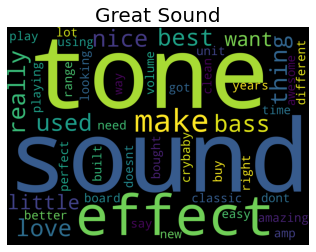

In [1078]:
# Generating the wordcloud with the values under the category dataframe
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(first_topic_words))
plt.imshow(cloud)
plt.axis('off')
plt.title('Great Sound', size=20)
plt.show()



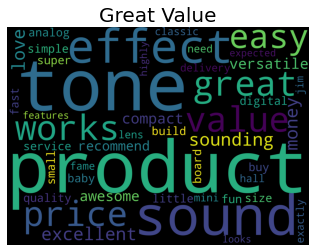

In [1079]:
# Generating the wordcloud with the values under the category dataframe
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(second_topic_words))
plt.imshow(cloud)
plt.axis('off')
plt.title('Great Value', size=20)
plt.show()


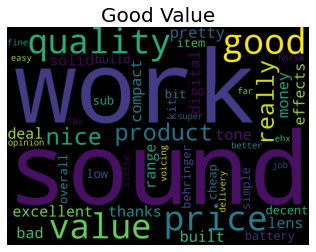

In [1080]:
# Generating the wordcloud with the values under the category dataframe
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(third_topic_words))
plt.imshow(cloud)
plt.axis('off')
plt.title('Good Value', size=20)
plt.show()


In [881]:
text = ' '.join(review for review in review_df.review)

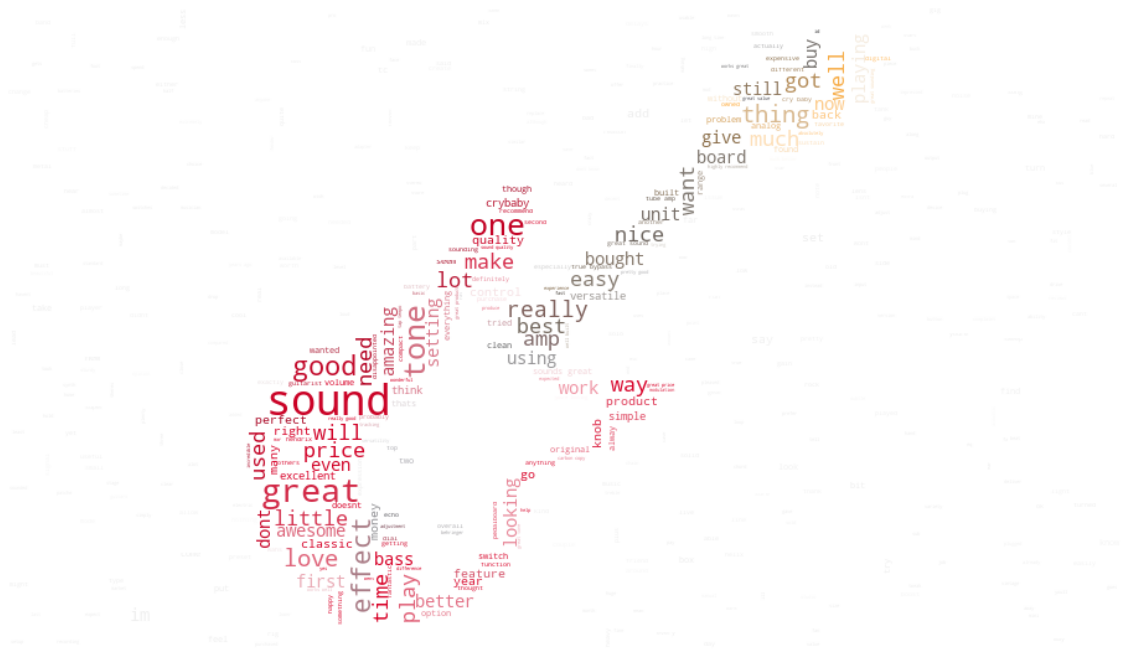

In [884]:
from PIL import Image
from wordcloud import ImageColorGenerator
# Generate a word cloud image
mask = np.array(Image.open("guitar.jpg"))
wordcloud_spa = WordCloud(stopwords=stopwords, background_color="white", max_words=1000, mask=mask).generate(text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,20])
plt.imshow(wordcloud_spa.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# store to file
# plt.savefig("img/spa_wine.png", format="png")
plt.show()

In [1072]:
forest.class_weight

In [802]:
review_df['review_ratings'] = review_df.review_ratings.astype(int)
neg_review_df = review_df[review_df.review_ratings == 1]
neg_review_df.head()

,listing,overall_rating,price,link,review,review_ratings,search,topic
10,"Boss DS-1 Distortion Pedal, Orange",4.5,$13.00,https://www.google.com/aclk?sa=L&ai=DChcSEwiJz...,save your money or buy one used this pedal sit...,1,fuzz pedal,Great Sound
13,"Boss DS-1 Distortion Pedal, Orange",4.5,$13.00,https://www.google.com/aclk?sa=L&ai=DChcSEwiJz...,this product is so pointless cheap for a reaso...,1,fuzz pedal,Great Sound
41,"Boss DS-1 Distortion Pedal, Orange",4.5,$13.00,https://www.google.com/aclk?sa=L&ai=DChcSEwiJz...,almost the worst distortion pedal ever these ...,1,fuzz pedal,Great Sound
57,"Boss DS-1 Distortion Pedal, Orange",4.5,$13.00,https://www.google.com/aclk?sa=L&ai=DChcSEwiJz...,brittle and gross dont waste your money or tim...,1,fuzz pedal,Great Sound
58,"Boss DS-1 Distortion Pedal, Orange",4.5,$13.00,https://www.google.com/aclk?sa=L&ai=DChcSEwiJz...,worst distortion pedal this is the worst disto...,1,fuzz pedal,Great Sound


In [803]:
tfidf_vectorizer = TfidfVectorizer(strip_accents = 'unicode',
                                stop_words = my_stop_words,
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.8,
                                min_df = 10,
                                ngram_range=(1,1))

nmf_tfidf = NMF(n_components=3)

tfidf = tfidf_vectorizer.fit_transform(neg_review_df.review)

nmf_tfidf.fit(tfidf)
print_top_words(nmf_tfidf, tfidf_vectorizer.get_feature_names(), 10)

Topic #0: sound good tone sounds dont thing low way effect used
Topic #1: great buy product poor service customer matter terrible tone quality
Topic #2: working junk did day work worked stopped tried different stop



In [804]:
doc_topics = nmf_tfidf.transform(tfidf)

In [805]:
topics = ['Good Sound', 'Poor Service', "Stopped Working"]
topic_list = []
for row in doc_topics:
    topic_list.append(topics[row.argmax()])

## Visualizing Topics

Most representative review for each topic.

In [813]:
review_df.head()

,listing,overall_rating,price,link,review,review_ratings,search,topic,topic_perc_contrib
0,"Boss DS-1 Distortion Pedal, Orange",4.5,$13.00,https://www.google.com/aclk?sa=L&ai=DChcSEwiJz...,this one slays it i will start by saying that ...,5,fuzz pedal,Great Value,0.029300
1,"Boss DS-1 Distortion Pedal, Orange",4.5,$13.00,https://www.google.com/aclk?sa=L&ai=DChcSEwiJz...,years of boss goodness so boss is years old a...,5,fuzz pedal,Great Sound,0.047223
2,"Boss DS-1 Distortion Pedal, Orange",4.5,$13.00,https://www.google.com/aclk?sa=L&ai=DChcSEwiJz...,i would buy this again and will recommend this...,5,fuzz pedal,Great Sound,0.024884
3,"Boss DS-1 Distortion Pedal, Orange",4.5,$13.00,https://www.google.com/aclk?sa=L&ai=DChcSEwiJz...,legendary pedal immortalized hall of fame the ...,5,fuzz pedal,Great Sound,0.034081
4,"Boss DS-1 Distortion Pedal, Orange",4.5,$13.00,https://www.google.com/aclk?sa=L&ai=DChcSEwiJz...,boss delivers here very nicely a thirty five y...,5,fuzz pedal,Great Sound,0.040630


In [887]:
review_df['review_ratings'] = review_df['review_ratings'].astypepe(int)
topic_group = review_df.groupby('topic')
most_representative = pd.DataFrame()
for i, grp in topic_group:
    most_representative = pd.concat([most_representative, grp.sort_values(['topic_perc_contrib'], ascending=False).head(3)], axis=0)


In [888]:
most_representative.review[3215]

'great pedal great pedal '

Do my topics correlate with anything?

In [994]:
sns.set_palette('gnuplot')

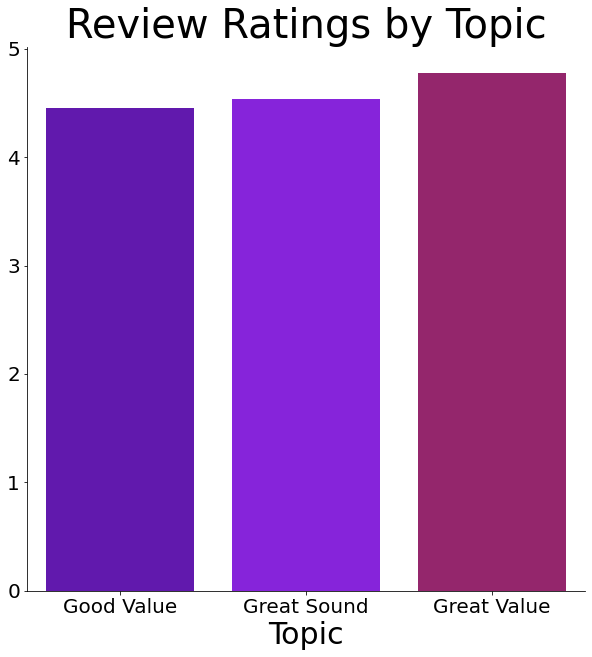

In [995]:
topic_ratings = topic_group['review_ratings'].mean()
plt.figure(figsize=(10,10))
sns.barplot(topic_ratings.index, topic_ratings.values)
plt.title('Review Ratings by Topic', size=40)
plt.xticks(size=20)
plt.xlabel(xlabel="Topic",size=30)
plt.yticks(size=20)
sns.despine()

In [972]:
topics = topic_ratings.index

In [1009]:
# review_df['price'] = review_df['price'].str.replace('$', '').str.replace(',','').astype(float)
topic_group = review_df.groupby('topic')

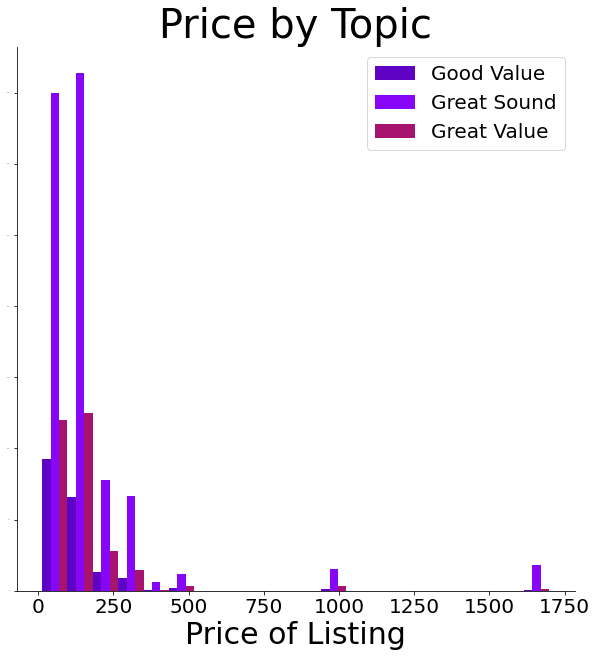

In [1071]:
sns.set_palette('gnuplot')
plt.figure(figsize=(10,10))
values = []
labels = []
for topic, g in topic_group['price']:
    values.append(g.values)
    labels.append(topic)
plt.hist(values,bins=20,rwidth=20, label=labels)
plt.legend(loc='best', prop={'size': 20})
plt.title('Price by Topic', size=40)
plt.xticks(size=20)
plt.xlabel(xlabel="Price of Listing",size=30)
plt.yticks(size=0)
sns.despine()

In [974]:
topic_ratings.index

Index(['Good Value', 'Great Sound', 'Great Value'], dtype='object', name='topic')

In [1001]:
review_df['price'] = review_df['price'].astype(int)

In [1006]:
review_df[review_df.price > 1000].listing

0      Line 6 Helix Floorboard Multi-Effects Pedal
1      Line 6 Helix Floorboard Multi-Effects Pedal
2      Line 6 Helix Floorboard Multi-Effects Pedal
3      Line 6 Helix Floorboard Multi-Effects Pedal
4      Line 6 Helix Floorboard Multi-Effects Pedal
                          ...                     
195    Line 6 Helix Floorboard Multi-Effects Pedal
196    Line 6 Helix Floorboard Multi-Effects Pedal
197    Line 6 Helix Floorboard Multi-Effects Pedal
198    Line 6 Helix Floorboard Multi-Effects Pedal
199    Line 6 Helix Floorboard Multi-Effects Pedal
Name: listing, Length: 200, dtype: object

## Word Embedding
My computer blew up when trying this, I'll probably try this later with google collab since they have gpu support.

In [283]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
best_freq = count_vect.fit_transform(best_reviews).toarray()
best_tokens = count_vect.get_feature_names()
worst_freq = count_vect.fit_transform(worst_reviews).toarray()
worst_tokens = count_vect.get_feature_names()

### FastText

In [ ]:
!pip install Cython --install-option="--no-cython-compile"
!pip install fasttext
# download pre-trained language word vectors from one of 157 languges  https://fasttext.cc/docs/en/crawl-vectors.html
# it will take some time, about 5 minutes
import fasttext
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')


/home/dyllanjr/anaconda3/envs/metis/lib/python3.8/site-packages/pip/_internal/commands/install.py:243: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
     |████████████████████████████████| 2.1 MB 1.6 MB/s eta 0:00:01
Skipping wheel build for Cython, due to binaries being disabled for it.
    Running setup.py install for Cython ... done
     |████████████████████████████████| 68 kB 1.1 MB/s eta 0:00:011
  Created wheel for fasttext: filename=fasttext-0.9.2-cp38-cp38-linux_x86_64.whl size=3025876 sha256=a778dc1f5c9406030c43f8b3ecac28a91b1d01cb53b9796a20c7a55e8060bccb
  Stored in directory: /home/dyllanjr/.cache/pip/wheels/93/61/2a/c54711a91c418ba06ba195b1d78ff24fcaad8592f2a694ac94
Successfully built fasttext


In [ ]:
print(model.most_similar(positive=['woman', 'king'], negative=['man']))


# Playing with Glove

In [39]:
# NLP tools
import nltk
from genism.models import FastText

# Data tools
import numpy as np
import pandas as pd

pedal_df = corpus['delay_pedal']
pos, neg = best_and_worst_products['delay_pedal']
pos_sents = pedal_df[pedal_df['listing'] == pos]['review']
neg_sents = pedal_df[pedal_df['listing'] == neg]['review']


ModuleNotFoundError: No module named 'genism'

In [11]:
# NLP tools
import nltk
import gensim

# Data tools
import numpy as np
import pandas as pd

In [ ]:
model_ted = FastText(sentences_ted, size=100, window=5, min_count=5, workers=4,sg=1)
